# Summarize Data

The `features` module packs a set of data summarization tools to calculate total counts, lengths, areas, and basic descriptive statistics of features and their attributes within areas or near other features. You can access these tools using the `summarize_data` sub module.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summarize-Data" data-toc-modified-id="Summarize-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summarize Data</a></span><ul class="toc-item"><li><span><a href="#Aggregate-points" data-toc-modified-id="Aggregate-points-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Aggregate points</a></span><ul class="toc-item"><li><span><a href="#Aggregate-earthquakes-by-state" data-toc-modified-id="Aggregate-earthquakes-by-state-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Aggregate earthquakes by state</a></span></li></ul></li></ul></li></ul></div>

## Aggregate points
In this example, let us observe how to use `aggregate_points` tool to summarize data from spot measurements by area. To learn more about this tool and the formula it uses, refer to the documentation [here](http://doc.arcgis.com/en/arcgis-online/use-maps/aggregate-points.htm)

In [ ]:
# connect to GIS
from arcgis.gis import GIS
gis = GIS("portal url", "username", "password")

<Item title:"World Earthquake Locations" type:Feature Layer Collection owner:api_data_owner>
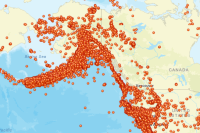

In [7]:
eq_search = gis.content.search(query="title:World Earthquake Locations owner:api_data_owner", item_type="Feature Layer Collection", max_items=1)
eq_item = eq_search[0]
eq_item

<Item title:"USA States (Generalized)" type:Feature Layer Collection owner:arcgis_python>
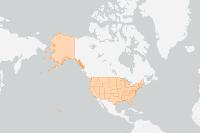

In [8]:
# search for USA states - area / polygon data
states_search = gis.content.search("title:'USA States (Generalized)'", 
                                   "feature layer", max_items=-1)
states_item = states_search[0]
states_item

Lets draw the layers on a map and observe how they are distributed


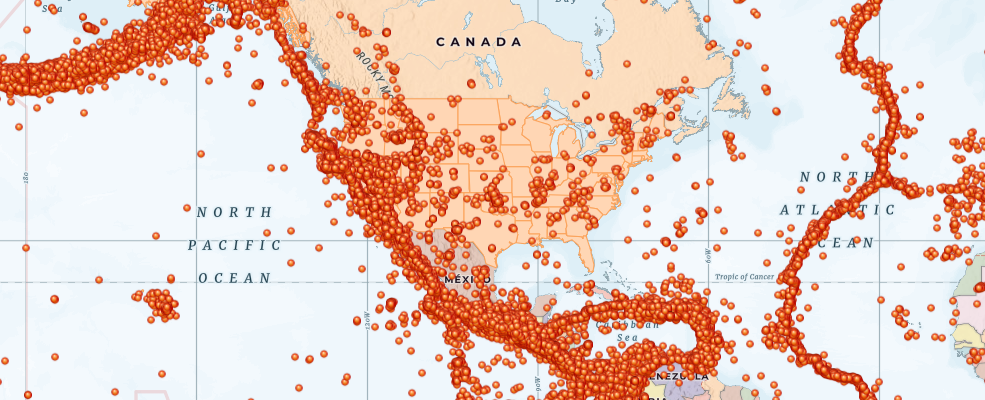

In [26]:
map1 = gis.map("USA")
map1

In [23]:
map1.center = [36, -98]
map1.zoom = 3

In [24]:
map1.add_layer(states_item)

In [25]:
map1.add_layer(eq_item)

### Aggregate earthquakes by state
As you can see, a number of earthquakes fall on the boundary of tectonic plates ([ring of fire](https://en.wikipedia.org/wiki/Ring_of_Fire)). However, there are a few more dispersed into other states. It would be interesting to aggregate all the earthquakes by state and plot that as a chart. 

The `aggregate_points` tool in the `summarize_data` sub module is a valid candidate for such analyses. The example below shows how to run this tool using ArcGIS API for Python.

To start with, let us access the layers in the states and earthquakes items and view their attribute information to understand how the data can be summarized

In [27]:
eq_fl = eq_item.layers[0]
states_fl = states_item.layers[0]

We have accessed the layers in the items as `FeatureLayer` objects. We can query the `fields` property to understand what kind of attribute data is stored in the layers

In [28]:
#query the fields in eq_fl layer
for field in eq_fl.properties.fields:
    print(field['name'])

Event_Id
Community_Decimal_Intensity
Event_Detail
Distance_from_Epicenter__degree
Felt_Reports
Azimuthal_Gap__degrees_
Event_Magnitude
Magnitude_Type
Shake_Intensity
Source_Network
Seismic_Stations
Location_Name
Residual_Travel_Time__seconds_
Event_Significance
Network_Sources
Review_Status
Event_Time
Event_Title
Tsunami_Warning
Event_Type
Product_Types
Last_Updated
Event_Page
Latitude
Longitude
Elevation__meters_
Depth__kilometers_
OBJECTID
Event_Time_1
Event_Type_1
ObjectId2


In [31]:
field_names = [f["name"] for f in states_fl.properties.fields]

In [33]:
for a,b,c,d,e in zip(field_names[0::10], field_names[1::10], field_names[2::10], field_names[3::10], field_names[4::10]):
    print(f"{a:17}{b:17}{c:17}{d:17}{e:17}")
print(f"{field_names[56]:17}{field_names[57]:17}")

FID              STATE_NAME       STATE_FIPS       SUB_REGION       STATE_ABBR       
BLACK            AMERI_ES         ASIAN            HAWN_PI          HISPANIC         
AGE_5_9          AGE_10_14        AGE_15_19        AGE_20_24        AGE_25_34        
AGE_85_UP        MED_AGE          MED_AGE_M        MED_AGE_F        HOUSEHOLDS       
MHH_CHILD        FHH_CHILD        FAMILIES         AVE_FAM_SZ       HSE_UNITS        
CROP_ACR12       AVE_SALE12       SQMI             Shape__Area      Shape__Length    
Shape__Area_2    Shape__Length_2  


Let us aggreate the points by state and summarize the `magnitude` field and use `mean` as the summary type.

In [105]:
# this cell will take a few minutes to execute because of several data points
from arcgis.features import summarize_data
sum_fields = ['Event_Magnitude Mean', 'Depth__kilometers_ Min']
eq_summary = summarize_data.aggregate_points(point_layer = eq_fl,
                                            polygon_layer = states_fl,
                                            keep_boundaries_with_no_points=False,
                                            summary_fields=sum_fields)

{"cost": 478.947}


When running the tool above, we did not specify a name for the `output_name` parameter. Hence the analyses results were not stored on the portal, instead stored in the variable `eq_summary`.

In [106]:
eq_summary

{'aggregated_layer': <FeatureCollection>, 'group_summary': ''}

In [107]:
# access the aggregation feature colleciton
eq_aggregate_fc = eq_summary['aggregated_layer']

#query this feature collection to get a data as a feature set
eq_aggregate_fset = eq_aggregate_fc.query()

`FeatureSet` objects support visualizing attribute information as a pandas dataframe. This is a neat feature since you do not have to iterate through each feature to view their attribute information.

Let us view the summary results as a pandas dataframe table. Note, the `aggregate_points` tool appends the polygon layer's original set of fields to the analysis result in order to provide context.

In [108]:
aggregation_df = eq_aggregate_fset.sdf
aggregation_df.head()

,OBJECTID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,...,GlobalID,Shape__Area_2,Shape__Length_2,Shape_Length,Shape_Area,mean_Event_Magnitude,min_Depth__kilometers_,Point_Count,AnalysisArea,SHAPE
0,1,Wyoming,56,Mountain,WY,598332,6.1,563626,5.8,511279,...,{9DC7C7AC-FE50-46FF-A98A-BC9B99E0CED0},474117105945.773438,2775149.430913,2775149.430947,474117105972.575684,4.550545,-1.4,110,253293.67329,"{""rings"": [[[-11583195.4614, 5115880.653200000..."
1,3,Alaska,02,Pacific,AK,744733,1.3,710231,1.2,473576,...,{FC1D546E-050D-40E0-8674-D380F839AD76},8101401247192.390625,59249543.508505,59249543.507812,8101401247161.800781,4.474101,-3.0,2802,1493247.177689,"{""rings"": [[[-17959594.8053, 8122953.575199999..."
2,5,North Dakota,38,West North Central,ND,793399,11.2,672591,9.5,605449,...,{4C973C13-C535-45DD-B5CB-0BD837DAE90D},400989888326.039062,2688189.824234,2688189.824286,400989888305.082947,5.5,0.0,1,183403.48984,"{""rings"": [[[-10990621.962, 5770462.616400003]..."
3,6,South Dakota,46,West North Central,SD,880051,11.4,814180,10.6,699392,...,{2064228A-2CC4-4E74-B492-34EF98939518},392302335744.371094,2824245.235541,2824245.23589,392302335746.93811,4.3,0.0,8,199912.09036,"{""rings"": [[[-11442350.6328, 5311257.036700003..."
4,7,Delaware,10,South Atlantic,DE,971403,491.7,897934,454.5,618617,...,{C83CE019-1814-4B07-8111-6B414909808F},8823228994.324219,535395.672895,535395.672768,8823228992.748075,4.1,9.87,1,5321.669252,"{""rings"": [[[-8427672.8732, 4658497.009999998]..."


Let's narrow down the output fields to view the output fields from the `summarize_data()` operation.

In [109]:
aggregation_df[["STATE_NAME","SUB_REGION","STATE_ABBR","POP2010","POP10_SQMI","mean_Event_Magnitude","min_Depth__kilometers_"]].head()

,STATE_NAME,SUB_REGION,STATE_ABBR,POP2010,POP10_SQMI,mean_Event_Magnitude,min_Depth__kilometers_
0,Wyoming,Mountain,WY,563626,5.8,4.550545,-1.4
1,Alaska,Pacific,AK,710231,1.2,4.474101,-3.0
2,North Dakota,West North Central,ND,672591,9.5,5.5,0.0
3,South Dakota,West North Central,SD,814180,10.6,4.3,0.0
4,Delaware,South Atlantic,DE,897934,454.5,4.1,9.87


Let's narrow this data down further to only those states that have had more than 25 earthquakes over the span of this data (1900 - 2023)

In [116]:
agg_gt25_df = aggregation_df.loc[aggregation_df["Point_Count"] > 25]

In [117]:
len(agg_gt25_df)

15

Thus, over the time span of this data, only 15 of the 50 US States have had more than 25 earthquakes. Let us plot a bar chart to view which states had the most earthquakes

<Axes: xlabel='STATE_NAME'>

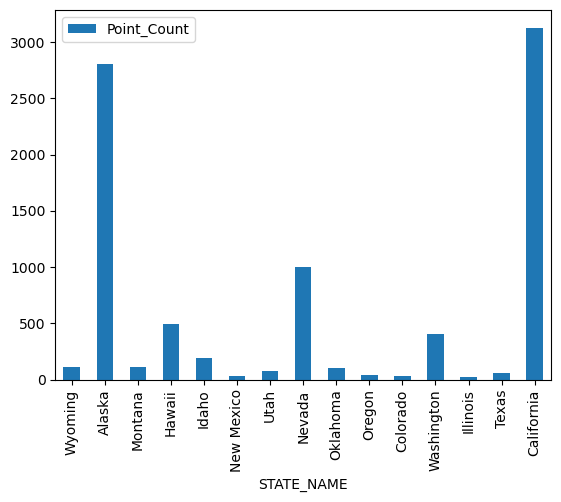

In [118]:
%matplotlib inline
agg_gt25_df.plot('STATE_NAME','Point_Count', kind='bar')

California and Alaska clearly top the list with the most earthquakes. Let us view what the average intensity and minimum depth is in the plots below:

array([<Axes: title={'center': 'min_Depth__kilometers_'}, xlabel='STATE_NAME'>,
       <Axes: title={'center': 'mean_Event_Magnitude'}, xlabel='STATE_NAME'>],
      dtype=object)

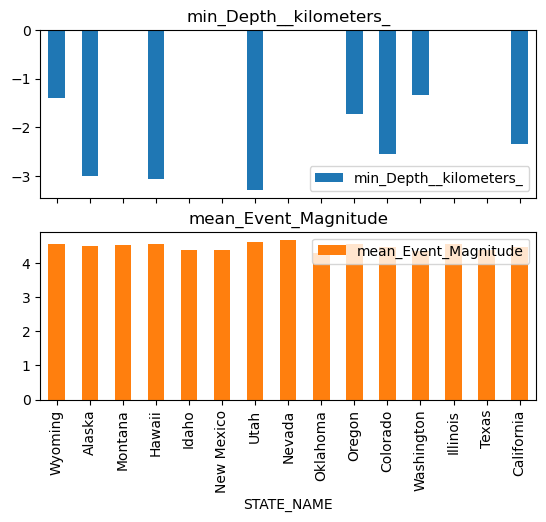

In [119]:
agg_gt25_df.plot('STATE_NAME',['min_Depth__kilometers_', 'mean_Event_Magnitude'],kind='bar', subplots=True)